 ##  Применение моделей машинного обучения для прогнозирования снижения покупательской активности на основе поведенческих и финансовых данных


В данной работе будет проведён анализ данных постоянных клиентов онлайн-магазина с целью прогнозирования уровня снижения их покупательской активности в течение следующих трёх месяцев.
Для этого используются данные о взаимодействии компании с клиентами, продуктовом и поведенческом профиле покупателей, а также финансовые показатели за последние месяцы.

Мы исследуем взаимосвязи между различными группами признаков, включая коммуникационные каналы, активность на сайте, типы и категории покупок, а также динамику выручки.

Цель: построить модель, предсказывающую вероятность снижения активности постоянных клиентов в следующие 3 месяца, используя поведенческие, коммуникационные, продуктовые и финансовые данные.

На основе прогноза и анализа прибыльности сегментировать клиентов и предложить персонализированные маркетинговые стратегии для удержания.

План:

1.Предобработка данных

Загрузка и очистка данных из трех датасетов.

Обработка пропущенных значений и приведение данных к нужным форматам.

2.Исследовательский анализ данных

Описание и визуализация основных признаков клиентов.

Отбор клиентов с покупательской активностью не менее трёх месяцев.

Построение графиков для каждого признака.

3.Корреляционный анализ признаков в датасете

Выявление взаимосвязей между признаками и мультиколленеарности.

4.Моделирование

Обучение моделей с использованием пайплайнов

Оценка точности моделей и выбор наилучших моделей для предсказания.

5.Анализ важности признаков:

Оценка важности признаков для лучшей модели и построение графиков важности с помощью метода SHAP. 

6.Сегментация покупателей

Выбор группы покупателей и предложение как увеличить её покупательскую активность

7.Общий вывод.


#### Описание данных 

- Датасет 1: market_file.csv

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

id — номер покупателя в корпоративной базе данных.

Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

Тип сервиса — уровень сервиса, например «премиум» и «стандарт».

Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.

Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.

Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.

Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.

Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.

Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

- Датасет 2: market_money.csv

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

id — номер покупателя в корпоративной базе данных.

Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.

Выручка — сумма выручки за период.

- Датасет 3: market_time.csv

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

id — номер покупателя в корпоративной базе данных.

Период — название периода, во время которого зафиксировано общее время.

минут — значение времени, проведённого на сайте, в минутах.



- Датасет 4: money.csv

Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

id — номер покупателя в корпоративной базе данных.

Прибыль — значение прибыли.



### Загрузка данных

In [1]:
!pip install shap -q
!pip install --upgrade scikit-learn -q
!pip install matplotlib==3.5.0 -q

import pandas as pd
import matplotlib.pyplot as plt   
from scipy import stats as st
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import f1_score, classification_report

import shap


from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore')


Загрузим файлы с данными и получим общую информацию о датасетах.

In [2]:
market = pd.read_csv('/datasets/market_file.csv', sep=',')
market_money = pd.read_csv('/datasets/market_money.csv', sep=',')
market_time = pd.read_csv('/datasets/market_time.csv', sep=',')
money = pd.read_csv('/datasets/money.csv', sep=';')


In [3]:
market.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


In [4]:
market_money.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


In [5]:
market_time.head(10)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


In [6]:
money.head(10)

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"
5,215353,"3,95"
6,215354,"3,62"
7,215355,"5,26"
8,215356,"4,93"
9,215357,"4,66"


Видим, что в датасете money значения в столбце "Прибыль"  числовые значения записаны через запятую, приведём их к типу float с точкой.

In [7]:
money['Прибыль'] = money['Прибыль'].str.replace(',', '.').astype(float)

Таким образом, данные соответствуют описанию, все признаки присутствуют.

### Предобработка данных

Проверим данные на наличие пропусков и дубликатов.

In [8]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Пропусков нет, данные выглядят корректно, проверим на дубликаты.

In [9]:
print(market.duplicated().sum())

0


In [10]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Пропусков тоже нет, проверим на дубликаты.

In [11]:
print(market_money.duplicated().sum())

0


In [12]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Пропусков нет, проверим на дубликаты.

In [13]:
print(market_time.duplicated().sum())

0


In [14]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Пропусков тоже нет, проверим на дубликаты.

In [15]:
print(money.duplicated().sum())

0


Таким образом, в данных нет пропусков и дубликатов и они подходят для дальнейшего анализа.

## Исследовательский анализ данных

Проведём исследовательский анализ для датасета market с информацией о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

#### 1.Проанализиурем количественные признаки из датасета market.


1.Исследуем показатель `Маркет_актив_6_мес`- среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев.

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64


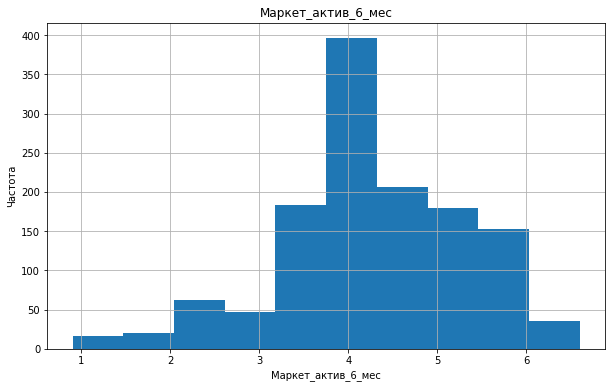

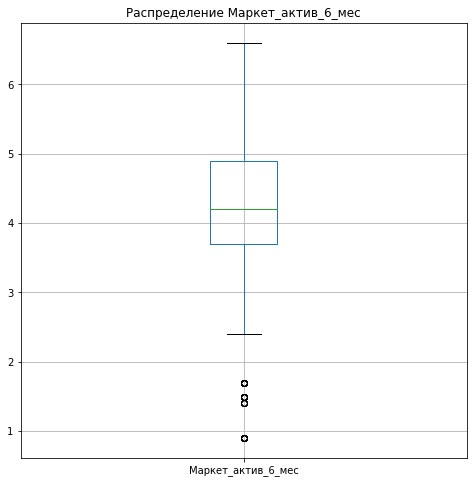

In [16]:
def analyze_column(df, column):
    
    print(df[column].describe())
    
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    df[column].hist(bins=10)
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    # Построение boxplot
    plt.figure(figsize=(8, 8))
    df.boxplot(column=column)
    plt.title(f'Распределение {column}')
    plt.grid(True)
    plt.show()
    
    
analyze_column(market, 'Маркет_актив_6_мес')

Выводы:

- Распределение приближено к нормальномму
- Есть несколько выбросов — наблюдения со значением < 2.0, вероятно,несколько клиентов с крайне низкой маркетинговой активностью. Данные выглядят реалистично (например, клиенты, которых почти не трогала реклама). 

2.Исследуем показатель маркет_актив_тек_мес - количество маркетинговых коммуникаций в текущем месяце.

In [17]:
market_activ = market['Маркет_актив_тек_мес'].value_counts() # проверим количество уникальных значений и их частоту
print(market_activ)

4    669
5    323
3    308
Name: Маркет_актив_тек_мес, dtype: int64


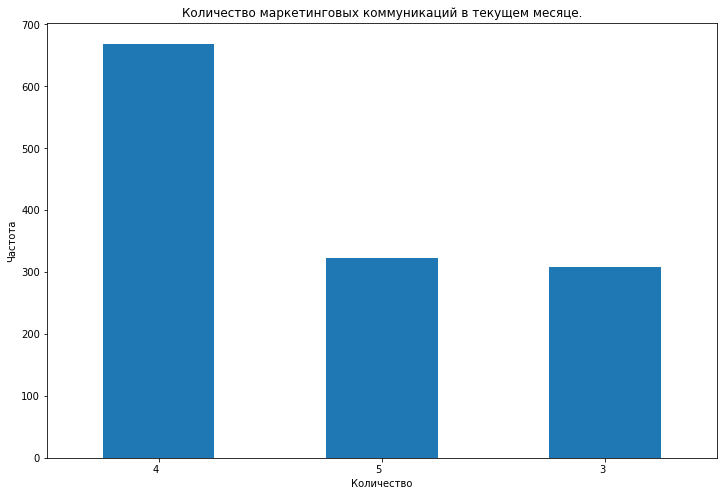

In [18]:
plt.figure(figsize=(12, 8))
market_activ.plot(kind='bar')  # построим наглядный график
plt.xticks(rotation=0,ha='right')
plt.title('Количество маркетинговых коммуникаций в текущем месяце.')
plt.xlabel('Количество')
plt.ylabel('Частота');


Из графика видно, что наиболее частое число маркетинговых коммуникаций в текущем месяце равно 4.

3. Исследуем показатель Длительность- значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64


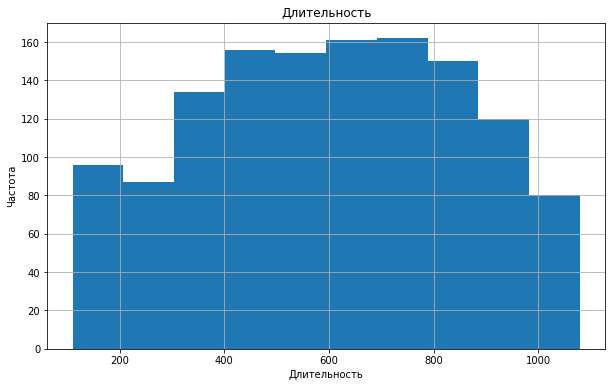

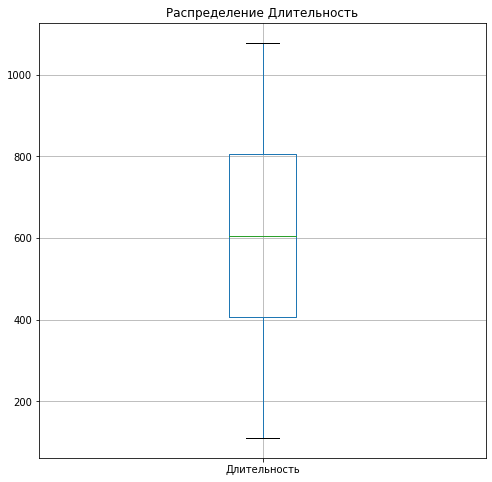

In [19]:
def analyze_column(df, column):
    
    print(df[column].describe())
    
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    df[column].hist(bins=10)
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    # Построение boxplot
    plt.figure(figsize=(8, 8))
    df.boxplot(column=column)
    plt.title(f'Распределение {column}')
    plt.grid(True)
    plt.show()
    
    
analyze_column(market, 'Длительность')

Выводы:

- Распределение похоже на близкое к равномерному.
- Нет выраженных выбросов
    

4. Исследуем показатель Акционные_покупки- среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64


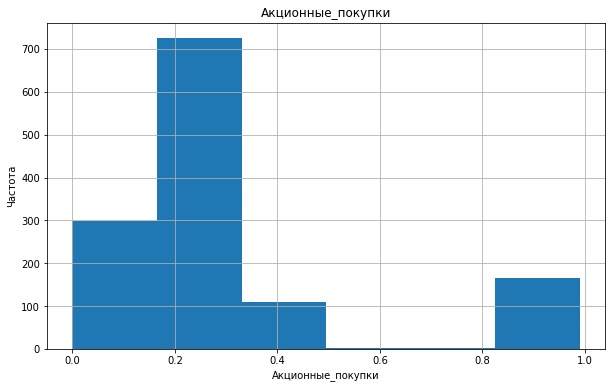

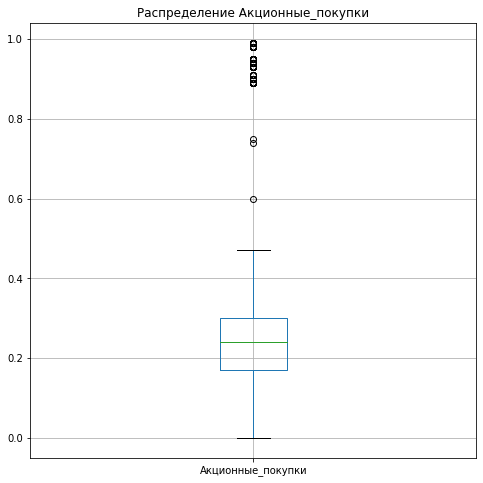

In [20]:
def analyze_column(df, column):
    
    print(df[column].describe())
    
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    df[column].hist(bins=6)
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    # Построение boxplot
    plt.figure(figsize=(8, 8))
    df.boxplot(column=column)
    plt.title(f'Распределение {column}')
    plt.grid(True)
    plt.show()
    
    
analyze_column(market, 'Акционные_покупки')

Выводы:
- Распределение выглядит асимметричо.
- Есть небольшой пик около 1.0 — то есть у части клиентов практически все покупки — акционные.
- Присутсвуют выбросы. однако эти выбросы выглядят логично — клиенты, активно покупающие по акциям.


5. Исследуем показатель Средний_просмотр_категорий_за_визит - сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64


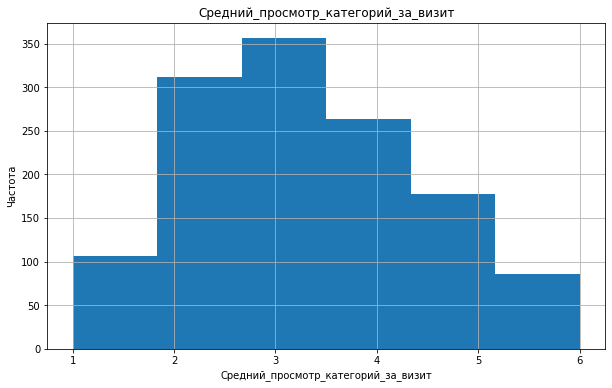

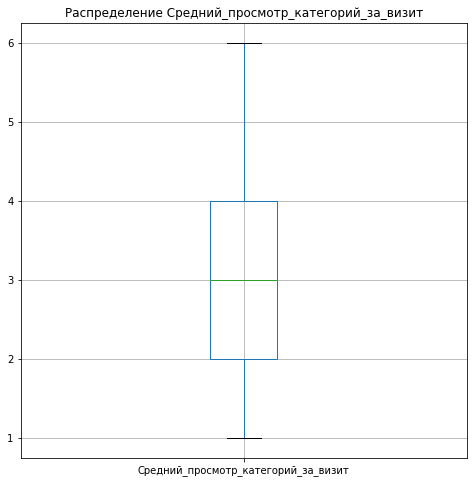

In [21]:
def analyze_column(df, column):
    
    print(df[column].describe())
    
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    df[column].hist(bins=6)
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    # Построение boxplot
    plt.figure(figsize=(8, 8))
    df.boxplot(column=column)
    plt.title(f'Распределение {column}')
    plt.grid(True)
    plt.show()
    
    
analyze_column(market, 'Средний_просмотр_категорий_за_визит')

Выводы:
- Распределение близко к нормальному.
- Большинство пользователей в среднем смотрят 2–4 категории за визит.
- Распределение без выбросов.

6. Исследуем показатель Неоплаченные_продукты_штук_квартал - общее число неоплаченных товаров в корзине за последние 3 месяца.

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64


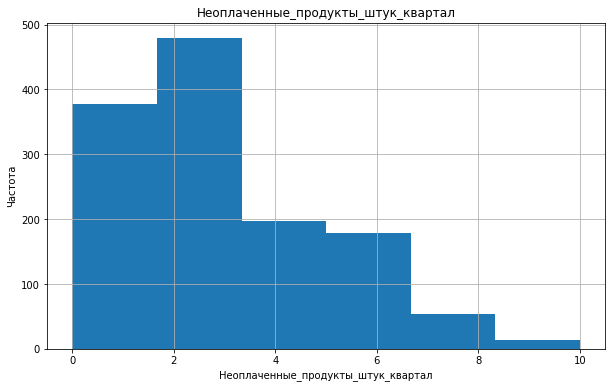

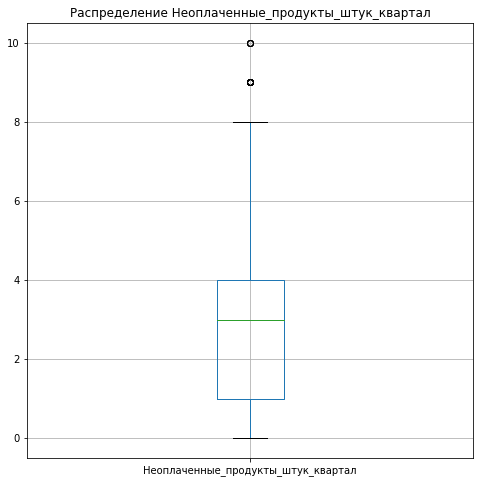

In [22]:
def analyze_column(df, column):
    
    print(df[column].describe())
    
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    df[column].hist(bins=6)
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    # Построение boxplot
    plt.figure(figsize=(8, 8))
    df.boxplot(column=column)
    plt.title(f'Распределение {column}')
    plt.grid(True)
    plt.show()
    
    
analyze_column(market, 'Неоплаченные_продукты_штук_квартал')

Выводы:
- Распределение асимметричное.
- Большинство клиентов имеют от 0 до 3 неоплаченных продуктов.
- Небольшое количество клиентов имеют значения 6–10 — вероятно, это редкие случаи.

7.Исследуем показатель Ошибка_сервиса -  число сбоев, которые коснулись покупателя во время посещения сайта.

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64


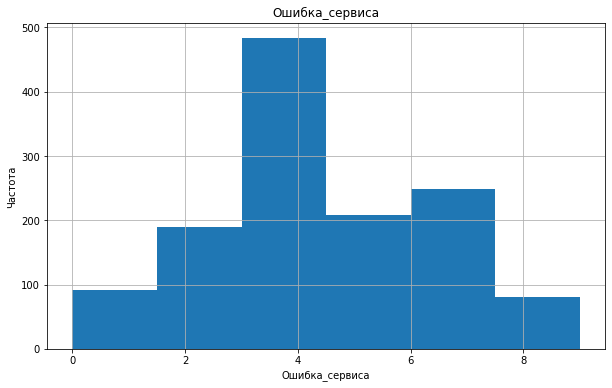

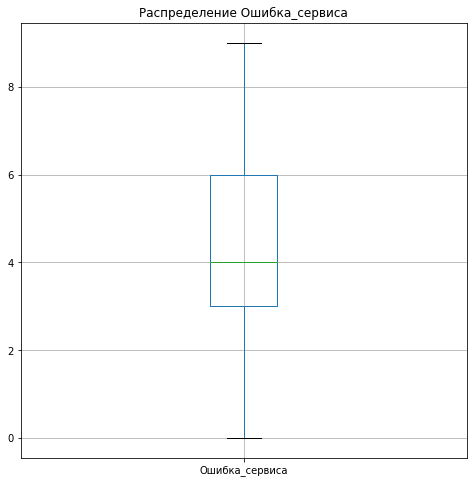

In [23]:
def analyze_column(df, column):
    
    print(df[column].describe())
    
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    df[column].hist(bins=6)
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    # Построение boxplot
    plt.figure(figsize=(8, 8))
    df.boxplot(column=column)
    plt.title(f'Распределение {column}')
    plt.grid(True)
    plt.show()
    
    
analyze_column(market, 'Ошибка_сервиса')

Выводы:
- Распределение близко к нормальному. Наибольшее количество пользователей имело 3–5 ошибок.
- Выбросов нет. 

8. Исследуем показатель Страниц_за_визит- среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64


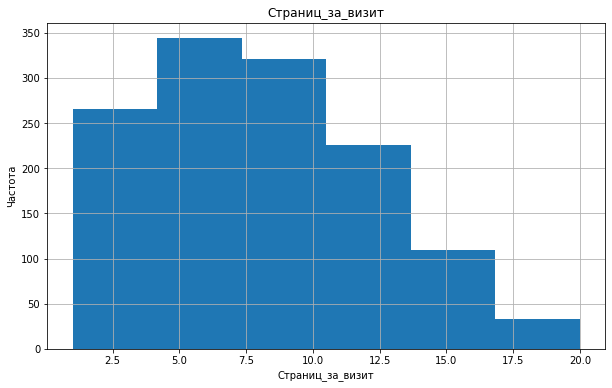

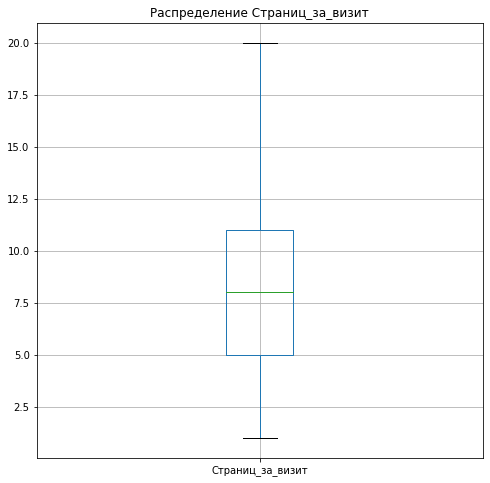

In [24]:
def analyze_column(df, column):
    
    print(df[column].describe())
    
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    df[column].hist(bins=6)
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    # Построение boxplot
    plt.figure(figsize=(8, 8))
    df.boxplot(column=column)
    plt.title(f'Распределение {column}')
    plt.grid(True)
    plt.show()
    
    
analyze_column(market, 'Страниц_за_визит')

Выводы:
- Распределение напоминает нормальное.
- Наиболее частые значения — от 5 до 11 страниц.
- Распределение симметричное, без явных выбросов.

#### Проанализируем категориальные признаки 

1.Исследуем показатель Покупательская активность- рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

In [25]:
clients_active = market['Покупательская активность'].value_counts() # проверим количество уникальных значений и их частоту
print(clients_active)

Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64


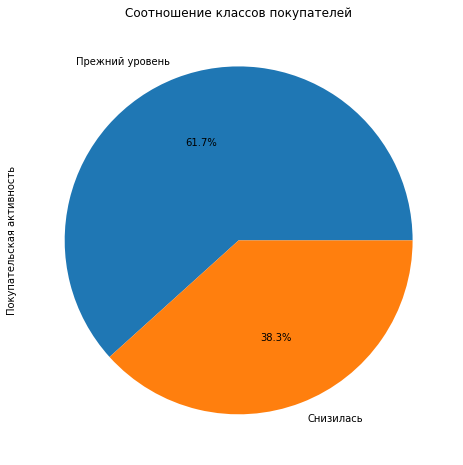

In [26]:
clients_active.plot(kind='pie', autopct='%1.1f%%', figsize=(8,8))
plt.title('Соотношение классов покупателей');

Видим, что  большинство покупателей остаются на прежнем уровне. 

2.Исследуем показатель Тип сервиса - уровень сервиса.

In [27]:
service_type = market['Тип сервиса'].value_counts() # проверим количество уникальных значений и их частоту
print(service_type)

стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64


Видим неявный дубликат, уберъм его

In [28]:
market['Тип сервиса'] = market['Тип сервиса'].replace({'стандартт': 'стандарт'})

In [29]:
service_type = market['Тип сервиса'].value_counts() # проверим количество уникальных значений и их частоту
print(service_type)

стандарт    924
премиум     376
Name: Тип сервиса, dtype: int64


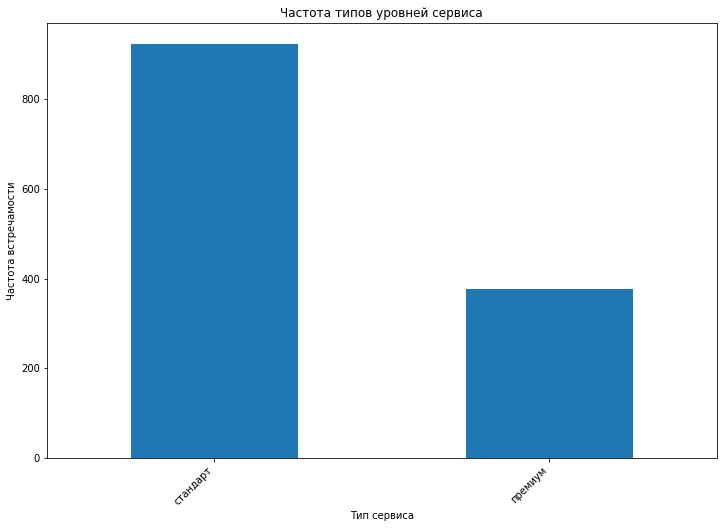

In [30]:
plt.figure(figsize=(12, 8))
service_type.plot(kind='bar')  # построим наглядный график
plt.xticks(rotation=45,ha='right')
plt.title('Частота типов уровней сервиса')
plt.xlabel('Тип сервиса')
plt.ylabel('Частота встречамости');

Видно, что тип сервиса "стандарт" встречается значительно чаще

3. Исследуем показатель Разрешить сообщать -информация о том, можно ли присылать покупателю дополнительные предложения о товаре.

In [31]:
permision = market['Разрешить сообщать'].value_counts() # проверим количество уникальных значений и их частоту
print(permision )

да     962
нет    338
Name: Разрешить сообщать, dtype: int64


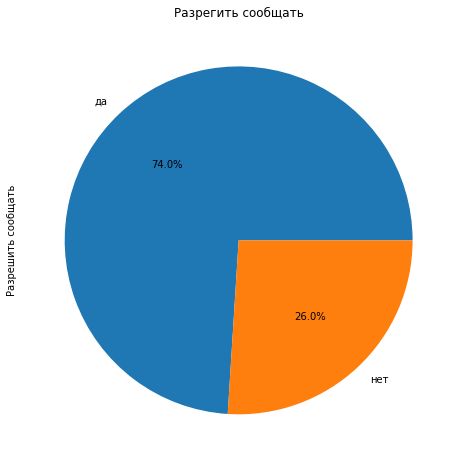

In [32]:
permision.plot(kind='pie', autopct='%1.1f%%', figsize=(8,8))
plt.title('Разрегить сообщать');

Видно, что большинство пользователей согласны получать дополнительные предложения.

4. Исследуем показатель Популярная_категория - самая популярная категория товаров у покупателя за последние 6 месяцев.

In [33]:
category = market['Популярная_категория'].value_counts() # проверим количество уникальных значений и их частоту
print(category)

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64


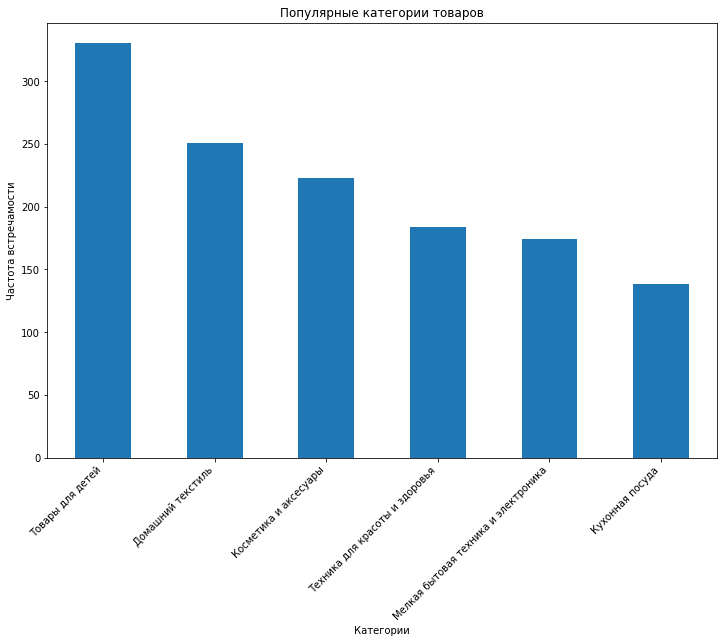

In [34]:
plt.figure(figsize=(12, 8))
category.plot(kind='bar')  # построим наглядный график
plt.xticks(rotation=45,ha='right')
plt.title('Популярные категории товаров')
plt.xlabel('Категории')
plt.ylabel('Частота встречамости');

Видим, что лидирует товары категории товары для детей, а самые низкие показатели у кухонной посуды. 

#### 2. Проанализиурем признаки из датасета market_money.

1. Исследуем показатель Период -  название периода, во время которого зафиксирована выручка.

In [35]:
period = market_money['Период'].value_counts() # проверим количество уникальных значений и их частоту
print(period)

предыдущий_месяц       1300
текущий_месяц          1300
препредыдущий_месяц    1300
Name: Период, dtype: int64


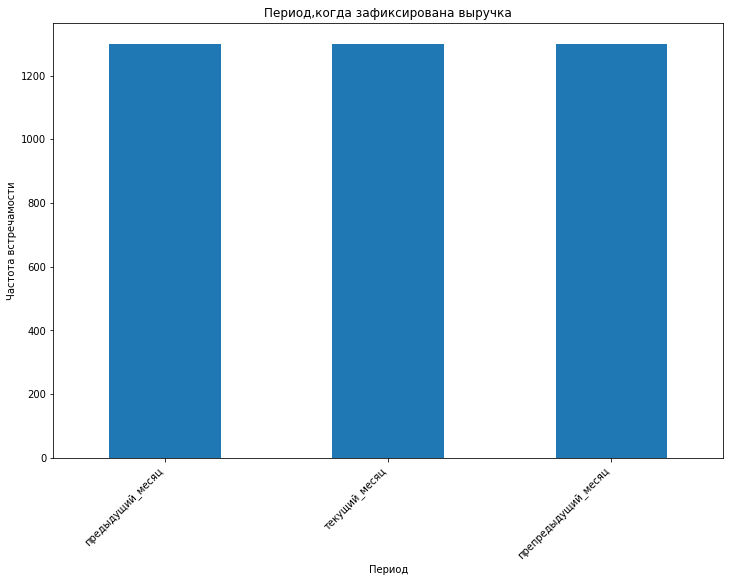

In [36]:
plt.figure(figsize=(12, 8))
period.plot(kind='bar')  # построим наглядный график
plt.xticks(rotation=45,ha='right')
plt.title('Период,когда зафиксирована выручка')
plt.xlabel('Период')
plt.ylabel('Частота встречамости');

Вывод:
- Все три периода содержат одинаковое количество записей.

2. Исследуем показатель Выручка - сумма выручки за период.

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64


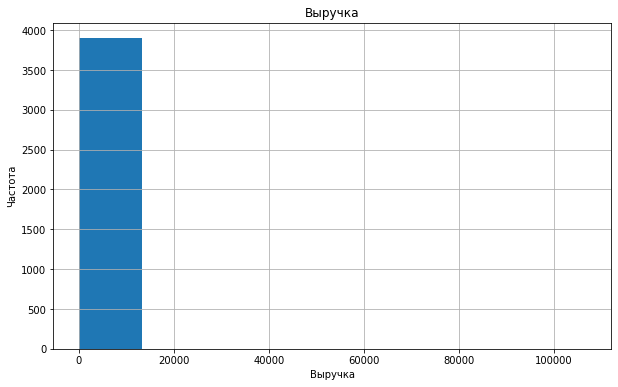

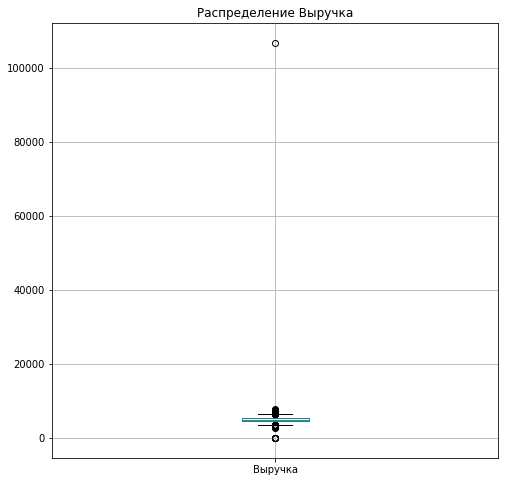

In [37]:
def analyze_column(df, column):
    
    print(df[column].describe())
    
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    df[column].hist(bins=8)
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    # Построение boxplot
    plt.figure(figsize=(8, 8))
    df.boxplot(column=column)
    plt.title(f'Распределение {column}')
    plt.grid(True)
    plt.show()
    
    
analyze_column(market_money, 'Выручка')

Выручка сильно смещена вправо, основная масса клиентов имеет выручку до 15 000.

На boxplot видны выбросы как в нижней, так и в верхней части. Особенно выделяется один экстремальный выброс (>100 000), но это может быть редкий случай, уберем его, для лучшего обучения модели. Также есть клиент с 0 выручкой, вероятно это неактивный пользователь.


In [38]:
market_money = market_money[(market_money['Выручка'] >= 2000) & (market_money['Выручка'] <= 20000)]


count    3893.000000
mean     5007.282918
std       679.724898
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: Выручка, dtype: float64


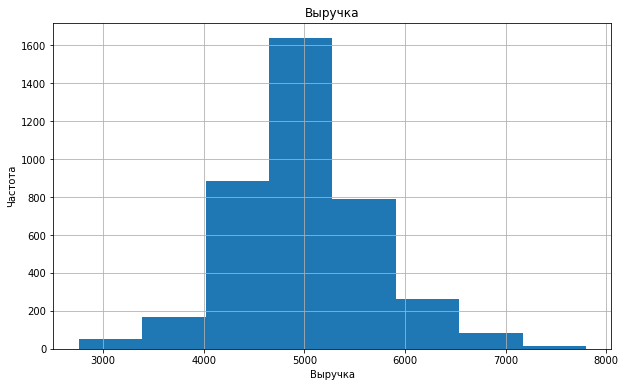

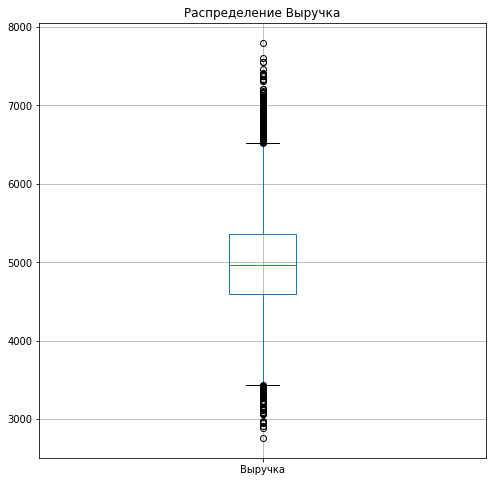

In [39]:
def analyze_column(df, column):
    
    print(df[column].describe())
    
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    df[column].hist(bins=8)
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    # Построение boxplot
    plt.figure(figsize=(8, 8))
    df.boxplot(column=column)
    plt.title(f'Распределение {column}')
    plt.grid(True)
    plt.show()
    
    
analyze_column(market_money, 'Выручка')

Можем сделать выводы, что основная масса пользователей тратит от 4000 до 6000.
Также есть клиенты, которые тратят выше 7000, их можно отнести к ценным клентам, котрые приносят большой вклад в прибыль, это  кандидаты для персонализированного обслуживания, VIP-программ, эксклюзивных предложений.




#### 3. Проанализиурем признаки из датасета market_time.

1. Исследуем показатель Период -  название периода, во время которого зафиксировано общее время.

In [40]:
periods = market_time['Период'].value_counts() # проверим количество уникальных значений и их частоту
print(periods)

предыдцщий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64


Удалим ошибку в слове предыдущий

In [41]:
market_time ['Период'] = market_time ['Период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})

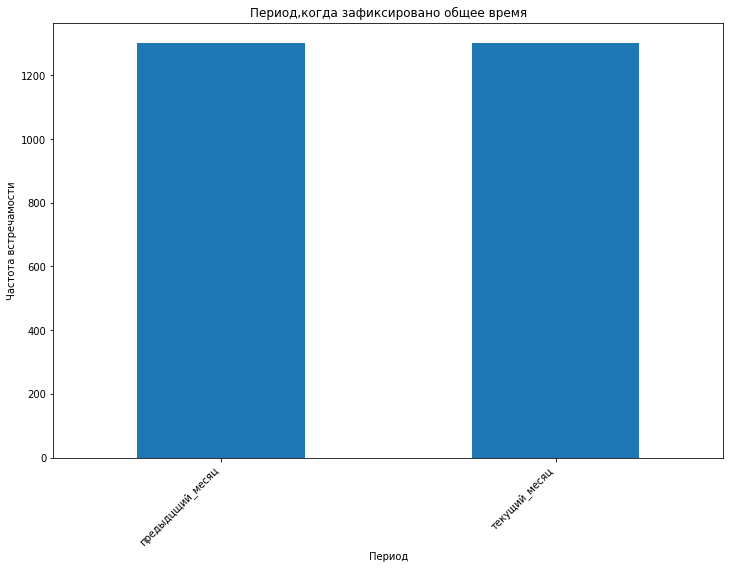

In [42]:
plt.figure(figsize=(12, 8))
periods.plot(kind='bar')  # построим наглядный график
plt.xticks(rotation=45,ha='right')
plt.title('Период,когда зафиксировано общее время')
plt.xlabel('Период')
plt.ylabel('Частота встречамости');

Количество пользователей в каждом периоде — одинаковое.

2. Исследуем показатель минут-  значение времени, проведённого на сайте, в минутах.

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


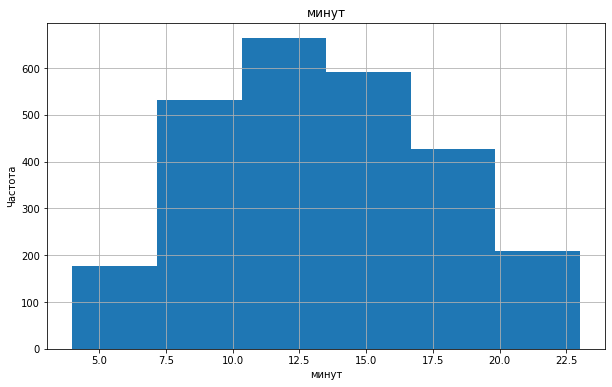

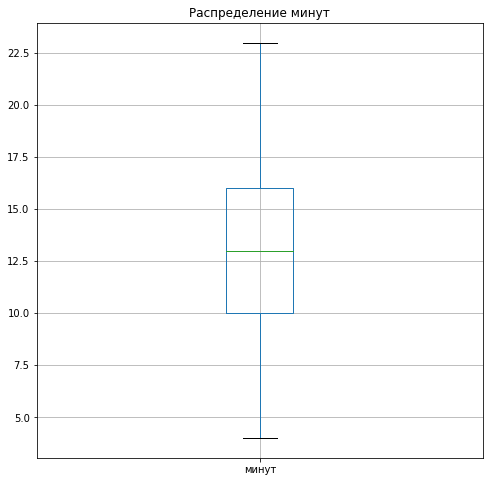

In [43]:
def analyze_column(df, column):
    
    print(df[column].describe())
    
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    market_time[column].hist(bins=6)
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    # Построение boxplot
    plt.figure(figsize=(8, 8))
    market_time.boxplot(column=column)
    plt.title(f'Распределение {column}')
    plt.grid(True)
    plt.show()
    
    
analyze_column(market_time, 'минут');

Выводы: 
- Распределение выглядит относительно симметричным. Не наблюдается явных выбросов

####  4. Проанализиурем признаки из датасета money. 

1. Исследуем показатель Прибыль - значение прибыли.

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64


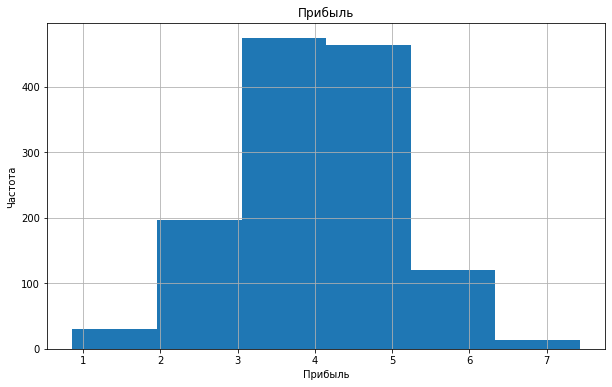

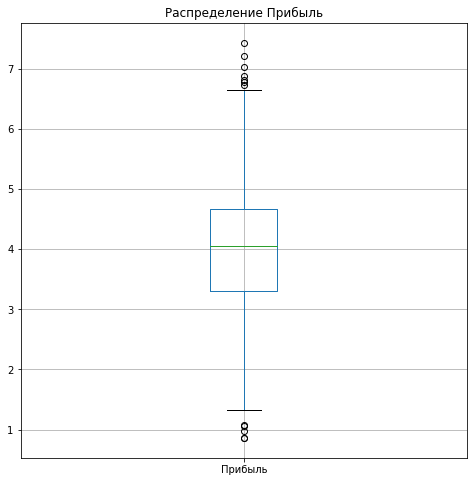

In [44]:
def analyze_column(df, column):
    
    print(df[column].describe())
    
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    df[column].hist(bins=6)
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    # Построение boxplot
    plt.figure(figsize=(8, 8))
    df.boxplot(column=column)
    plt.title(f'Распределение {column}')
    plt.grid(True)
    plt.show()
    
    
analyze_column(money, 'Прибыль');

Выводы: 

- Распределение близко к нормальному.
- Есть немного выбросов сверху и снизу — вероятно, редкие случаи, их лучше сохранить для анализа.

#### Отберём клиентов с покупательской активностью не менее трёх месяцев

Пользователь должен иметь ненулевую выручку в каждом из трёх месяцев.

In [45]:
active_client = market_money.query('Выручка > 0') # отбираем строки с выручкой > 0 

active_months = active_client.groupby('id')['Период'].nunique() # считаем количество месяцев с покупками для каждого клиента

active_ids = active_months[active_months >= 3].index # фильтруем клиентов, у кого активность не менее 3-х месяцах

market_money = market_money[market_money['id'].isin(active_ids)]


print(f"Клиентов с активностью не менее 3 месяцев: {market_money ['id'].nunique()}")

display(market_money )

Клиентов с активностью не менее 3 месяцев: 1296


,id,Период,Выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


### Выводы:

Таким образом, проанализировав датафреймы можно сказать:

- Данные в датасетах распределены относительно равномерно, есть выбросы в некотрых данных, но мы их оставим для обчучения модели.
- Клиентов с активностью не менее 3 месяцев: 1297 из 1300 — это почти все пользователи. Это говорит о высоком уровне вовлечённости базы.

### Объединение таблиц

Объединим таблицы market, market_money и market_time. 

При этом преобразуем таблицы с вручкой и временем в таблицы со столбцами для каждого периода.

In [46]:
money_pivot = market_money.pivot(index='id', columns='Период', values='Выручка') # преобразуем таблицу с выручкой
money_pivot.columns = [f"Выручка_{col}" for col in money_pivot.columns]
money_pivot.reset_index(inplace=True)

In [47]:
time_pivot = market_time.pivot(index='id', columns='Период', values='минут') # преобразуем таблицу с временем
time_pivot.columns = [f"Время_{col}" for col in time_pivot.columns]
time_pivot.reset_index(inplace=True)

In [48]:
# теперь соединим всё вместе по столбцу id

merged_df = market.merge(money_pivot, on='id', how='left')
data = merged_df = merged_df.merge(time_pivot, on='id', how='left')

print(data.shape)
display(data.head())


(1300, 18)


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,NaN,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [49]:
print("До объединения:", market.shape)
print("После объединения:", data.shape)

До объединения: (1300, 13)
После объединения: (1300, 18)


Таким образом, количество строк не изменилось, данные объеденены корректно.

### Теперь проанализируем распределение признаков по группам.

In [50]:
# поделим на две группы
active = data[data['Покупательская активность'] == 'Прежний уровень']
inactive = data[data['Покупательская активность'] == 'Снизилась']


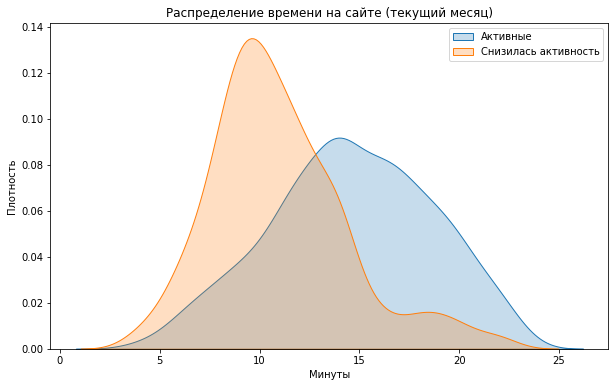

In [51]:
plt.figure(figsize=(10, 6))
sns.kdeplot(active['Время_текущий_месяц'], label='Активные', shade=True)
sns.kdeplot(inactive['Время_текущий_месяц'], label='Снизилась активность', shade=True)
plt.title("Распределение времени на сайте (текущий месяц)")
plt.xlabel("Минуты")
plt.ylabel("Плотность")
plt.legend()
plt.show()


Клиенты с падающей активностью проводят меньше минут на сайте, чем активные пользователи.
У них чаще встречаются значения в диапазоне 8–12 минут, тогда как у активных пользователей пики на 13–18 минут и выше.

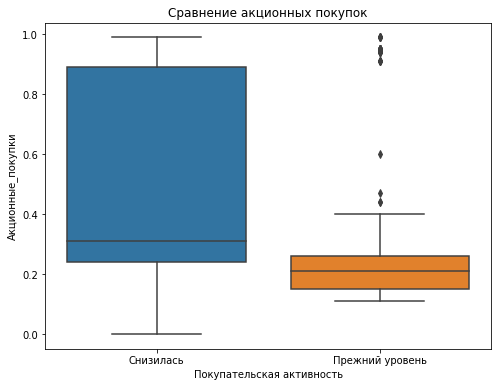

In [52]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Покупательская активность', y='Акционные_покупки', data=data)
plt.title("Сравнение акционных покупок")
plt.show()


Доля покупок по акциям у "неактивных" клиентов значительно выше.
У многих из них эта доля приближается к 1.0, то есть почти все покупки совершались исключительно по скидкам.
Вероятно, это клиенты ориентироаны на акции и они прекращают активность, если нет акций.



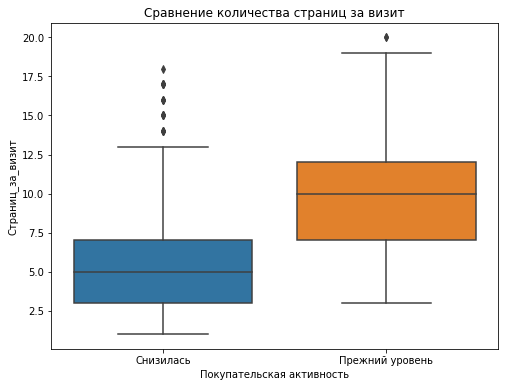

In [53]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Покупательская активность', y='Страниц_за_визит', data=data)
plt.title("Сравнение количества страниц за визит")
plt.show()


У клиентов со сниженной активностью меньше медианное значение количества страниц.

У активных пользователей медиана выше и разброс больше — они более глубоко исследуют сайт.

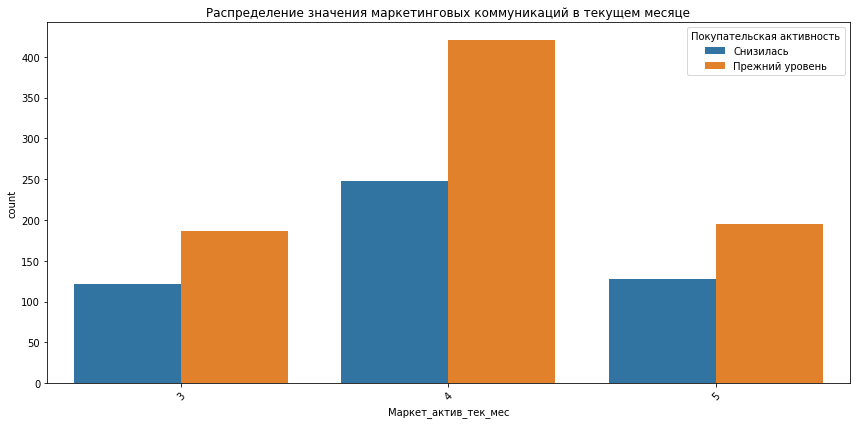

In [54]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Маркет_актив_тек_мес', hue='Покупательская активность', data=data)
plt.xticks(rotation=45)
plt.title("Распределение значения маркетинговых коммуникаций в текущем месяце")
plt.tight_layout()
plt.show()

Пользователи,у которых снизилась активность, чаще имеют средние и низкие значения маркетинговой активности.То есть они реже взаимодействуют с маркетинговыми рассылками, предложениями или акциями, которые продвигает платформа.

Эти клиенты слабо реагируют на маркетинговые инициативы, или их просто стало меньше в текущем месяце, может быть причиной снижения активности.

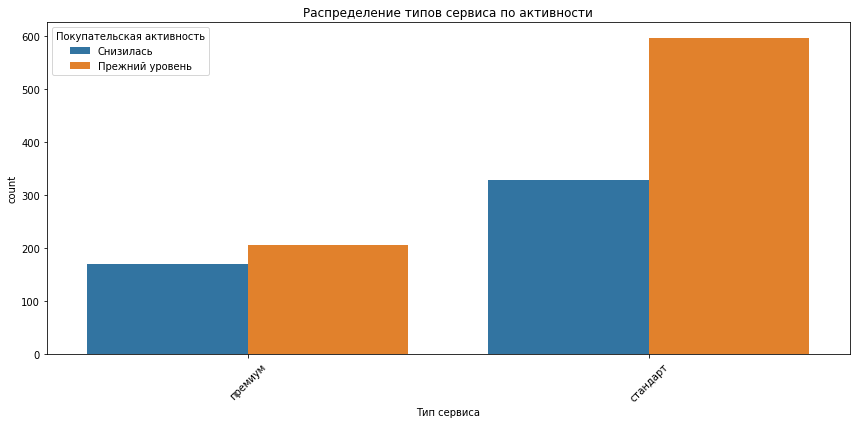

In [55]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Тип сервиса', hue='Покупательская активность', data=data)
plt.xticks(rotation=45)
plt.title("Распределение типов сервиса по активности")
plt.tight_layout()
plt.show()


Пользователи премиум-подписки чаще оказываются среди тех, чья активность снизилась. Среди пользователей стандартного сервиса наоборот — выше доля тех, кто остался активным.

Возможно, премиальные клиенты могут быть более требовательными, и если сервис не оправдал ожидания — они просто уходят.

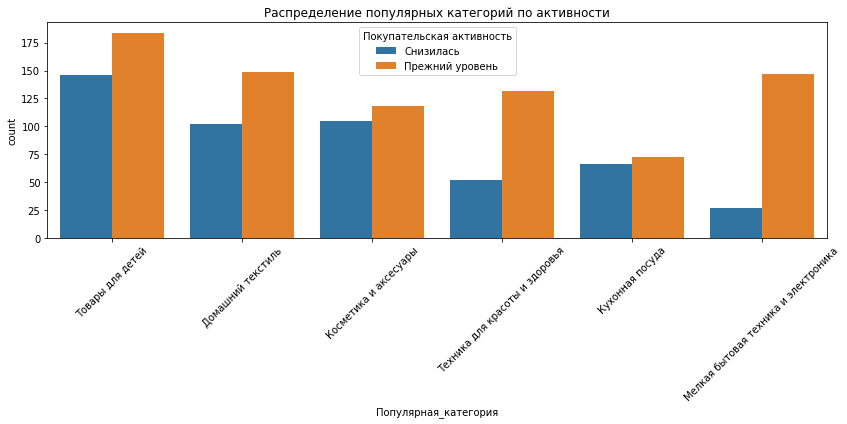

In [56]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Популярная_категория', hue='Покупательская активность', data=data)
plt.xticks(rotation=45)
plt.title("Распределение популярных категорий по активности")
plt.tight_layout()
plt.show()


Среди  клиентов со снижением активности заметно преобладают: товары для детей, домашний текстиль, красота и аксессуары,

А в категориях "Кухонная посуда" или "Мелкая бытовая техника" преобладают активные пользователи.

Клиенты, фокусирующиеся на категориях типа “Товары для детей” и “Домашний текстиль”, быстрее теряют интерес, возможно, из-за однократного спроса или низкой потребности в повторных покупках.

Таким образом портерт покупателя, со снижением активности :

- Время на сайте - ниже среднего: 8–12 минут.

- Акционные покупки - Преимущественно совершаются только по акциям.

- Страниц за визит - меньше, чем у активных.

- Маркетинговая активность - ниже — слабо вовлечены в рассылки, реже реагируют.

- Тип сервиса	- чаще премиум.

- Популярные категории - товары для детей, текстиль, бьюти — однократные покупки.



### Корреляционный анализ

In [57]:
data['Покупательская активность'] = data['Покупательская активность'].map({   # преобразуем категориальную переменнуюв числовые значения 0 и 1
    'Снизилась': 1,
    'Прежний уровень': 0
})


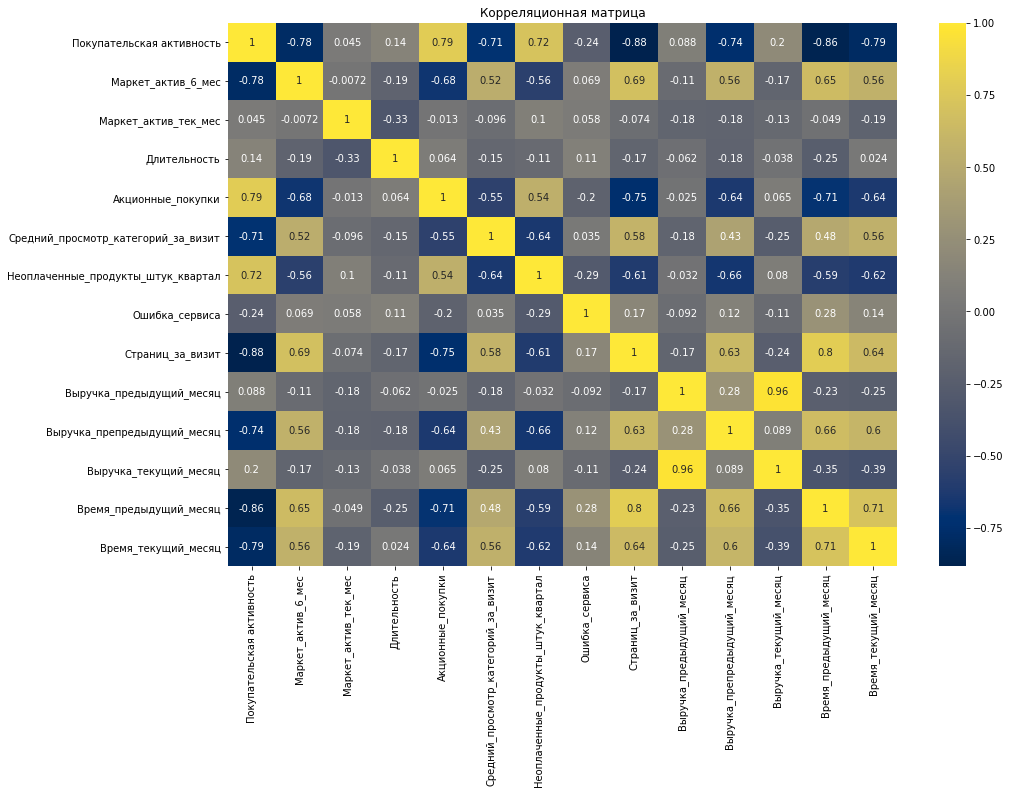

In [58]:
corr_matrix = data.drop(columns=['id']).select_dtypes(include='number').corr()


 # уберем id из расчета корреляции

plt.figure(figsize=(15, 10))
plt.title("Корреляционная матрица")
sns.heatmap(corr_matrix.corr(), annot=True, cmap='cividis');

Из матрицы видно:
 - 	Чем меньше страниц просматривал пользователь за визит, тем выше вероятность снижения активности. Сильная обратнаясвязь(−0.88).
 
 - Обратная корреляция покупатльской ативости и временеми за предыдущий месяц. Меньше времени на сайте — выше шанс снижения активности. Также Время_текущий_месяц подтверждает тенденцию — падение времени на сайте связано со снижением активности.
 
 - Обратная связь Маркет_актив_6_мес и поукательской активностью. Меньше активности в маркетинговых кампаниях за 6 мес — выше шанс потери.
 
 - Высокая корреляция между Акционными покупками и покупатльской ативностью. Те, кто совершал больше акционных покупок, чаще снижали активность — возможно, это люди, которые совершают покупки только по акциям..
 
 - Обратная корреляция между Средний_просмотр_категорий_за_визит и покупатеськой ативностью. Меньше интереса к товарам = снижение активности.
 
 - Неоплаченные_продукты_штук_квартал и пакупатеськой ативностью. Те, у кого больше неоплаченных товаров, чаще уходили.
 
 
Снижение активности пользователей сильно связано с их поведением на сайте:

- Смотрят меньше страниц,

- Меньше времени на сайте,

- Меньше вовлечены в маркетинг.

Некоторые признаки могут быть "предвестниками оттока":

- Количество неоплаченных товаров,

- Частота акционных покупок.



Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю, в нашем примере нет таких входных признаков, которые имеют такую сильую связь.
 

### Обучение моделей МО

Так как в нашей задаче нам важно находить тех, кто проявит активность(recal) и мы не хотим ошибаться часто и навязывать предложения не тем (precision). Поэтому логично сбалансировать оба показателя (recall и precision),также у нас есть небольшой дисбаланс классов, поэтому оптимальный выбором будет F1-score

In [59]:
data = data.set_index('id')  #  сделаем столбце id индексом,т.к он не учавствует в обучении

In [60]:
X = data.drop(columns=['Покупательская активность'])
y = data['Покупательская активность']
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# отбираем признаки
numeric_features = [
    'Длительность',
    'Акционные_покупки',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Страниц_за_визит',
    'Выручка_предыдущий_месяц',
    'Выручка_препредыдущий_месяц',
    'Выручка_текущий_месяц',
    'Время_предыдущий_месяц',
    'Время_текущий_месяц'
]

ordinal_features = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес']
nominal_features = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория', 'Ошибка_сервиса']

# пайплайны для категориальных и числовых
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='error', sparse_output =False))
])

ord_pipe = Pipeline([
    ('imputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputer_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())  
])

# общий препроцессор
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, nominal_features),
    ('ord', ord_pipe, ordinal_features),
    ('num', num_pipe, numeric_features)
], remainder='passthrough')

# общий пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# параметры для GridSearch
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5,10),
        'models__max_features': range(2, 7),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [SVC(kernel = 'poly', class_weight='balanced', random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 10),
        'models__gamma': np.logspace(-4, 1, 6),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    }
]

# обучение модели
grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train, y_train)

# результаты
print("Лучшая модель:", grid.best_estimator_)
print("\n Лучшие параметры:", grid.best_params_)
print("\n Лучшее значение F1:", grid.best_score_)


Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория',
                                                   'Ошибка_сервиса']),
                                                 ('ord',
                           

Таким образом, среди всех протестированных моделей лучше всего справилась SVC.

In [61]:
# тестируем модель на тестовой выборке
y_test_pred = grid.predict(X_test)
print(f'Метрика F1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')

Метрика F1 на тестовой выборке: 0.7807486631016043


### Проведем анализ важности признаков

PermutationExplainer explainer: 261it [06:22,  1.49s/it]                         


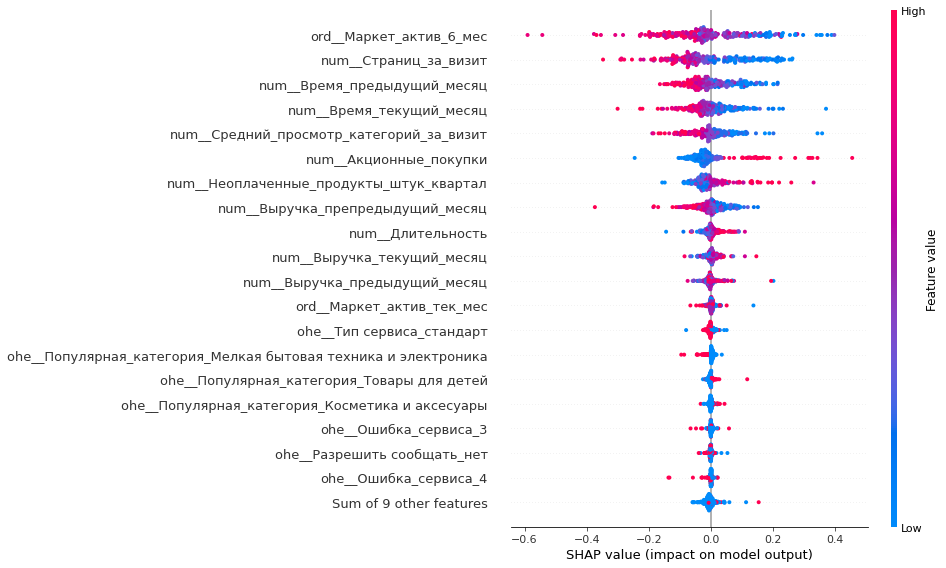

In [62]:
num_pipe_best = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


preprocessor_best = ColumnTransformer([
    ('ohe', ohe_pipe, nominal_features),
    ('ord', ord_pipe, ordinal_features),
    ('num', num_pipe_best, numeric_features)
], remainder='passthrough')


preprocessor_best.fit(X_train)

feature_names = preprocessor_best.get_feature_names_out()

X_train_transformed = preprocessor_best.fit_transform(X_train)
X_test_transformed = preprocessor_best.transform(X_test)


model = SVC(C=2, gamma=0.1, class_weight='balanced', probability=True, random_state=RANDOM_STATE)
model.fit(X_train_transformed, y_train)

explainer = shap.Explainer(model.predict, X_train_transformed, feature_names=feature_names)

shap_values = explainer(X_test_transformed)
shap.plots.beeswarm(shap_values, max_display=20)



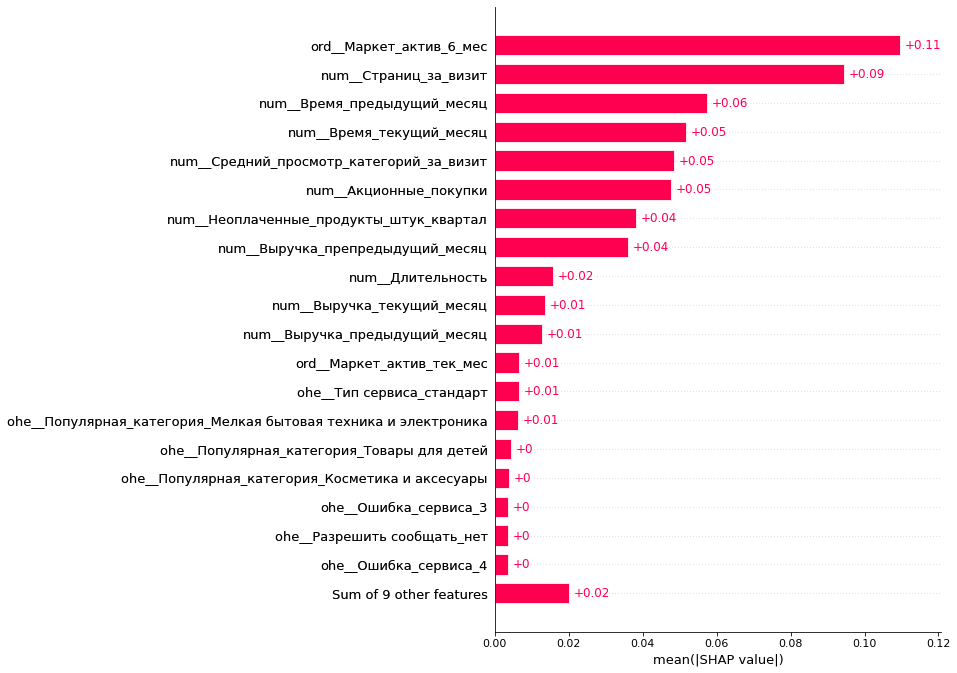

In [63]:
shap.plots.bar(shap_values, max_display=20)


Таким образом:

- Сильнее всего влияют на модель: уровень активности пользователя на маркетплейсе за последние 6 месяцев, Количество страниц, просмотренных за визит, Время, проведённое пользователем на платформе в предыдущем месяце, Время в текущем месяце, Акционные покупки, Средний просмотр категорий за визит.


- Мало значимые признаки: Популярная категория Косметика и аксесуары, Ошибка сервиса 5 и 3,Популярная категория Товары для детей, Популярная категория Техника для красоты и здоровья.


Как использовать это при моделировании и принятии решений:

- Фокус на важных признаках:

Признаки Маркет_актив, Время_на_платформе, Страниц_за_визит и т.п. действительно важны — стоит усиливать их сбор, точность и интерпретацию. Можно создать их комбинации или производные фичи, например, тренды вовлечённости.

Анализировать поведение пользователей с высокими значениями Маркет_актив_6_мес и большим временем/страницами за визит, т.к это лояльная аудитория, и с ними стоит активнее работать (персонализированные предложения, удержание).

- Оптимизация данных:

Малоинформативные признаки можно исключить при упрощении модели или отборе признаков, они только усложняют модель.

- Бизнес-применение:

Повышение удержания клиентов

Пользователи, которые неактивены в течение 6 месяцев, мало времени проводят на сайте, не просматривают товары — это высокий риск оттока.  Можно таргетировать таких клиентов реактивационными кампаниями, бонусами или индивидуальными предложениями, ему нужно срочно предложить промо или персональное письмо.

Пользователи, активные в течение 6 месяцев, дольше на платформе и с большим количеством просмотров страниц — более склонны к таргету модели (возможно, к покупке/удержанию/оттоку).
Маркетинг может использовать это для таргетинга и персонализации: например, усиливать вовлечение новых пользователей до достижения таких паттернов поведения.

Персонализация
Пользователи с высокой активностью -  интенсивное вовлечение (персональные рекомендации).

Те, кто часто делает акционные покупки — предложить больше промо.

- Оптимизация маркетинга:

Бюджет можно перенаправить на клиентов, у которых признаки влияют на модель сильнее (например, часто возвращаются, проводят много времени, смотрят много страниц).

Для пользователей с незначимыми признаками  нет смысла тратить много ресурсов — у них минимальное влияние на целевую бизнес-метрику.

Для стратегий сегментации
– Понять, чем отличаются клиенты с разными предсказаниями - сегментировать аудиторию - лучше таргетировать рекламу.

## Сегментация покупателей

Построим диаграмму рассеяния по прибилы и вероятности снижения активности.

In [64]:
data['Выручка'] = data[[ 
    'Выручка_предыдущий_месяц',         # рассчитаем среднюю выручку за 3 месяца
    'Выручка_препредыдущий_месяц',
    'Выручка_текущий_месяц'
]].mean(axis=1)


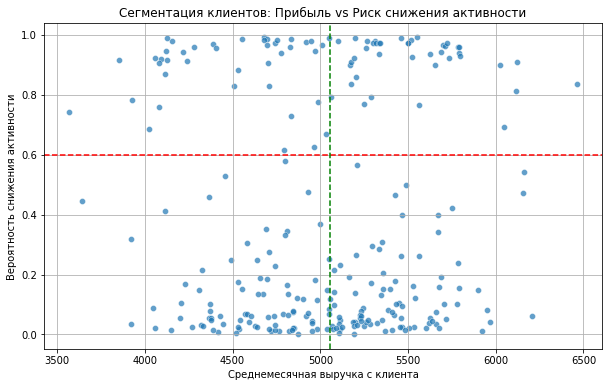

In [65]:
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names, index=X_test.index)

# вычисляем вероятности понижения активности
prob_low = model.predict_proba(X_test_df)[:, 1]

# получаем значения выручки для X_test
profit_test = data.loc[X_test.index, 'Выручка']  

# собираем датафрейм для анализа
profit_df = pd.DataFrame({
    'Выручка': profit_test,
    'Вероятность снижения активности': prob_low,
    'id': X_test.index
})



plt.figure(figsize=(10, 6))
sns.scatterplot(data=profit_df,
                x='Выручка',
                y='Вероятность снижения активности',
                alpha=0.7)

plt.axhline(y=0.6, color='red', linestyle='--', label='Порог вероятности > 0.5')
plt.axvline(x=profit_df['Выручка'].median(), color='green', linestyle='--', label='Медианная выручка')
plt.title('Сегментация клиентов: Прибыль vs Риск снижения активности')
plt.xlabel('Среднемесячная выручка с клиента')
plt.ylabel('Вероятность снижения активности')
plt.grid(True)
plt.show()


На основе графика выделели группу клиентов с высокой выручкой и высоким риском (в правом верхнем углу):
это ключевые клиенты, приносящие большую прибыль, но с высоким риском ухода или снижения активности, т.е те у кого выручка > 5000, вероятность > 0.5

Проведём исследование по этому сегменту:

In [66]:
# отбор ключевых клиентов по критериям
high_risk_clients = profit_df[
    (profit_df['Выручка'] > profit_df['Выручка'].median()) &
    (profit_df['Вероятность снижения активности'] > 0.5)
]

# кол-во таких клиентов
print(len(high_risk_clients))


43


Таки клиентов немного, но они важны для бизнеса.

In [67]:
high_risk_clients.describe()


,Выручка,Вероятность снижения активности,id
count,43.000000,43.000000,43.000000
mean,5536.033333,0.900860,215609.674419
std,334.681080,0.106275,279.373084
min,5061.900000,0.542862,215375.000000
25%,5264.783333,0.879064,215447.000000
50%,5499.966667,0.935730,215561.000000
75%,5729.683333,0.972554,215649.000000
max,6461.966667,0.991162,216636.000000


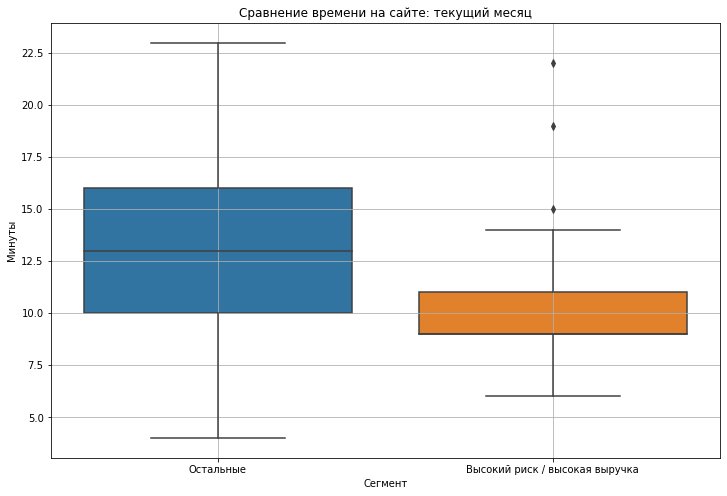

In [68]:
# сравним время на сайте с остальными сегментами

high_risk_clients = profit_df[
    (profit_df['Выручка'] > profit_df['Выручка'].median()) &
    (profit_df['Вероятность снижения активности'] > 0.5)
]['id']

data['Сегмент'] = 'Остальные'
data.loc[high_risk_clients, 'Сегмент'] = 'Высокий риск / высокая выручка'

plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='Сегмент', y='Время_текущий_месяц')
plt.title("Сравнение времени на сайте: текущий месяц")
plt.ylabel("Минуты")
plt.xlabel("Сегмент")
plt.grid(True)
plt.show()


Можно сделать такие выводы:

- клиенты "Высокий риск / высокая выручка" проводят меньше времени на сайте, чем остальные пользователи.У них медианное время заметно ниже (примерно 10 минут против 13+ у остальных). 

- Клиенты с высокой выручкой и высоким риском проводят меньше времени на сайте.

Это может указывать на: потерю интереса к платформе, снижение вовлечённости, отсутствие новинок или мотивации зайти, уход на доугие пдатформы конкурентов.





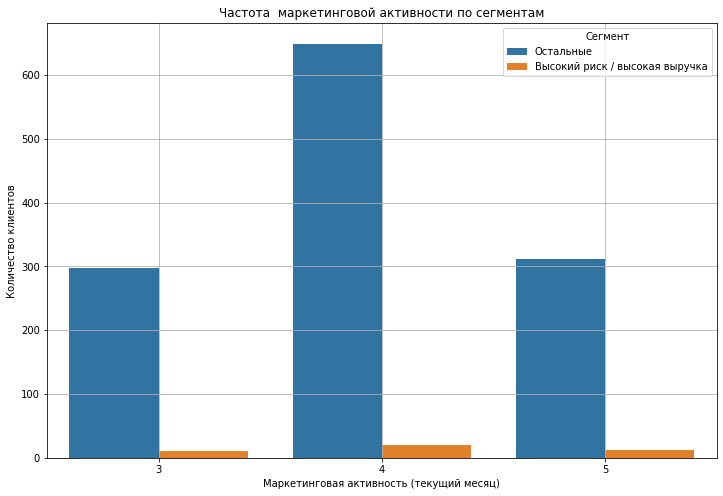

In [69]:
# сравним маркетинговую активность 

plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='Маркет_актив_тек_мес', hue='Сегмент')
plt.title("Частота  маркетинговой активности по сегментам")
plt.xlabel("Маркетинговая активность (текущий месяц)")
plt.ylabel("Количество клиентов")
plt.legend(title='Сегмент')
plt.grid(True)
plt.show()


Можем сделать выводы:

- Абсолютное количество "рискового" значительно ниже по сравнению с остальными (что логично — это малочисленный, но ценный сегмент). При этом распределение похоже на остальной пул: они также в основном имеют оценку 4.

- "Высокорисковый" сегмент получает маркетинговое воздействие — они участвуют в кампаниях и реагируют на них, но:
это не влияет сильно на их активность (из анализа выше — они меньше проводят времени на сайте).
Возможно, текущие предложения для них неперсонализированы, и они их игнорируют.



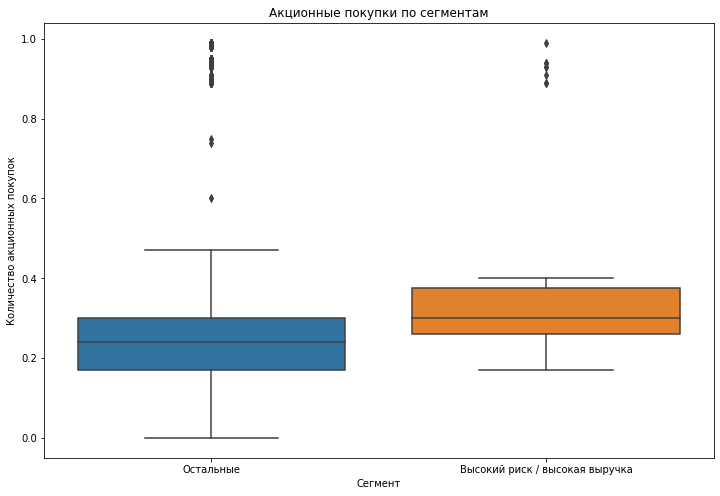

In [70]:
# сравним акционные покупки


plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='Сегмент', y='Акционные_покупки')
plt.title("Акционные покупки по сегментам")
plt.ylabel("Количество акционных покупок")
plt.xlabel("Сегмент")
plt.show()


Можем сделать такие выводы:

- Сегмент "Высокий риск / высокая выручка" имеет чуть более высокое медианное значение количества акционных покупок по сравнению с остальными. Несмотря на снижение времени на сайте и риск потери — они реагируют на скидки.


- Сегмент "Остальные": шире распределение. Есть множество выбросов — клиенты, которые делают много акционных покупок т.е реагируют более разно. Однако медиана чуть ниже, чем у "рисковых". 

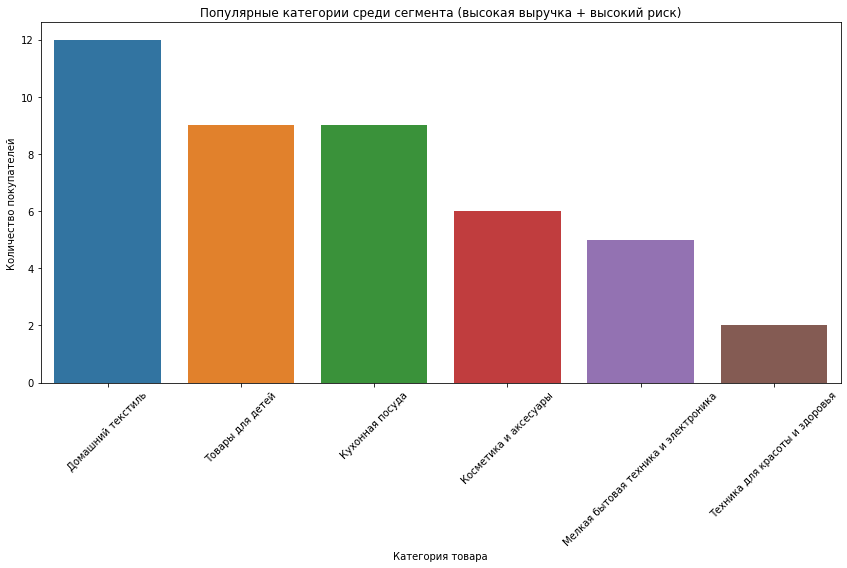

In [71]:
# сравним распределение категорий


high_value_risk = data[data['Сегмент'] == 'Высокий риск / высокая выручка']

plt.figure(figsize=(12, 8))
sns.countplot(data=high_value_risk, x='Популярная_категория', order=high_value_risk['Популярная_категория'].value_counts().index)
plt.title("Популярные категории среди сегмента (высокая выручка + высокий риск)")
plt.xticks(rotation=45)
plt.xlabel("Категория товара")
plt.ylabel("Количество покупателей")
plt.tight_layout()
plt.show()


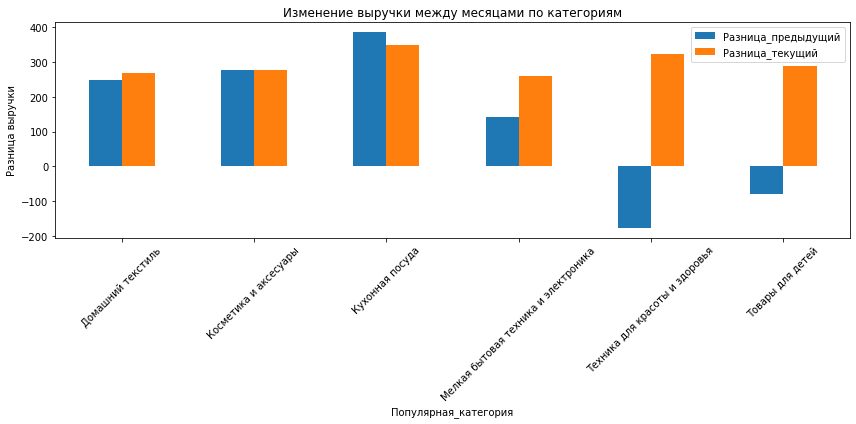

In [79]:
# посмотрим разницу выручки между периодами

pivot_df = data.groupby('Популярная_категория')[[
    'Выручка_препредыдущий_месяц', 
    'Выручка_предыдущий_месяц', 
    'Выручка_текущий_месяц'
]].mean()

pivot_df['Разница_предыдущий'] = pivot_df['Выручка_предыдущий_месяц'] - pivot_df['Выручка_препредыдущий_месяц']
pivot_df['Разница_текущий'] = pivot_df['Выручка_текущий_месяц'] - pivot_df['Выручка_предыдущий_месяц']

pivot_df[['Разница_предыдущий', 'Разница_текущий']].plot(kind='bar', figsize=(12,6))
plt.title('Изменение выручки между месяцами по категориям')
plt.ylabel("Разница выручки")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Рост выручки в текущем месяце наблюдается практически во всех категориях, включая те, где в предыдущем месяце был спад: это может говорить о сезонности, маркетинговой активности.

Категории с падением в прошлом месяце, но ростом в текущем: Техника для красоты и здоровья, Товары для детей.

Стабильный рост два месяца подряд: домашний текстиль, косметика и аксессуары, кухонная посуда - эти категории демонстрируют устойчивый рост, что делает их приоритетными для дальнейшего продвижения/инвестиций.

Мелкая бытовая техника и электроника - умеренный рост.


Выводы:

Категории с устойчивым ростом могут быть отличными кандидатами для усиления маркетинга или акций .

Категории с просадкой ранее, но восстановлением сейчас — стоит проанализировать, что повлияло на падение, и можно ли избежать его в будущем.



Можно сделать такие выводы: 

- Сегмент высокорисковых / доходных клиентов — ориентирован на дом и быт особенно текстиль, посуда, детские товары.

Возможно, это семейные клиенты, и эмоциональный маркетинг (уют, забота) может сработать лучше, чем просто скидка.

На основе данного исследования можно сделать такие выводы:

- Всего 42 клиента  выручкой выше медианы и высокой вероятностью снижения активности.Это ключевая группа, которую стоит удерживать, чтобы не потерять прибыль.

- Среднее время на сайте у клиентов из этого сегмента ниже, чем у остальных. Это может говорить о снижающемся интересе или неудовлетворённости.

- Топ категорий по популярности: домашний текстиль,товары для детей, кухонная посуда.

- Частота маркетинговых активностей не отличается существенно от других клиентов. Значит, текущие кампании неэффективны для этой группы - нужно персонализировать.

- Сегмент делает немного больше акционных покупок, чем остальные. Но в целом разница невелика — просто скидками их не удержать.

- Предпочтения в категориях — бытовой и семейный фокус. Это клиенты с домашним уклоном, которым важен комфорт,уют.


- Категории-лидеры (высокая выручка и популярность): домашний текстиль, кухонная посуда - можно усиливать вложения, акции, удержание.

-  Потенциал роста: товары для детей — недавний рост интереса. Мелкая техника — прирост выручки, но стоит расширить аудиторию.



#### Предложения по удержанию сегмента

- Разослать email или push-уведомления с персональными акциями, напоминаниями, рекомендациями.

- Персонализированные предложения по ключевым категориям

Акции или персональные предложения в Топ-категориях могут удержать клиентов с высоким риском ухода.

Например, подойдёт акция с ограничением по времени или подарок за повторную покупку в этих категориях.

- Программы лояльности, бонусы, экслюзивные предложения:

Получите эксклюзивное предложение» «Накопите бонусы за каждую покупку — не упустите привилегии»

- Возможно, стоит подключить персонального менеджера.


### Общий вывод

В данном проекте мы ставили задачу выявить особенности поведения клиентов из различных сегментов и спрогнозировать уровень снижения их покупательской активности в течение следующих трёх месяцев.
Также задача включала подбор лучшей модели для классификации клиентов по сегментам.

В распоряжении были данные о клиентах, включающие:

Информацию продуктовом поведении (наиболее частая категория в заказе, среднее число просматриваемых категорий).

Коммуникация с клиентом (тип сервиса, маркетинг 6 месяцев и т.д)

Поведение на сайте (время на сайте, минут за визит, число страниц и т.д)

Финансовое поведение (выручка в разные месяцы)

В данной работе были проведены следующие этапы:

- Предобработка включала:

Проверку датсетов, пропущенных значений, дубликатов.
Приведение данных к нужному формату.

- Исследовательский анализ: 

На данном этапе провели анализ всех признаков и построили матрицу корреляции.

-  Моделирование и выбор лучшей модели: 

Для предсказания сегмента клиента были протестированы следующие модели:

KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и SVC.

Для поиска лучшей модели мы использовали: 

- Подбор гиперпараметров (через GridSearchCV).

- Оценка f1-score метрики на тестовой выборке.

- На основе этого выбрали лучшую модель, ей оказалась SVC со Лзначением F1: 0.8378610904090357.


- Выбор сегмента и предложения для бизнес-целей:

Выделели группу клиентов с высокой выручкой и высоким риском:
это ключевые клиенты, приносящие большую прибыль, но с высоким риском ухода или снижения активности.

1. Маркетинговая активность

Клиенты из этого сегмента проявляют среднюю маркетинговую активность, схожую с остальными сегментами. Стоит нарастить маркетинговое взаимодействие, сфокусировавшись на удержание.

2. Акционные покупки

В среднем, этот сегмент чаще участвует в акционных предложениях, чем остальные. Следует использовать таргетированные акции, индивидуальные предложения, акции с ограниченным сроком.


3. Популярные категории

Наиболее востребованные категории товаров в этом сегменте: домашний текстиль, кухонная посуда, товары для детей, нужно персонализировать рассылки, пуши, исходя из этих категорий. 


4.  Бонус за возврат

Начисление бонусов за следующую покупку.


5. Бесплатная доставка 


6. Больше подборок по интересам, персональные рекомендации.


